# StatsForecast

> Model Training, Evaluation and Selection for multiple Time Series



:::{.callout-warning collapse="false"}
## Prerequesites
This Guide assumes basic familairty with StatsForecast covered in the [Quick Start](./Getting_Started_short.ipynb)
:::

Follow this article for a step to step guide on building a production-ready forecasting pipeline for multiple time series. 

For the example, we will use a classical benchmarking dataset from the M5 competition. The dataset features data for products sold *daily* across *several stores* for roughly five years. 

We will forecast at a product-store level. Forecasting at this level is also known as fine-grain demand forecasting. Therefore, you will train a series of models for every unique series and then select the best one. StatsForecast focuses on speed, simplicity, and scalability, which makes it ideal for this task. 


**Outline:**
* M5
    * 1. Read and explore the data.
    * 2. Train different models for multiple time series. You will train a set of models for every unique combination of time series. 
    * 3. Ensemble the models' forecasts to obtain production ready forecasts.
* M4
    * 1. Read and explore the data.
    * 2. Train different models for multiple time series. You will train a set of models for every unique combination of time series. 
    * 3. Ensemble the models' forecasts to obtain production ready forecasts.

**This guide does not cover:**

* Forecasting at scale using clusters on the cloud. 
    * [Forecast the M5 Dataset in 5min](./ETS_ray_m5.ipynb) using Ray clusters.
    * [Forecast the M5 Dataset in 5min](./Prophet_spark_m5.ipynb) using Spark clusters.
    * Learn how to predict [1M series in than 30min](https://www.anyscale.com/blog/how-nixtla-uses-ray-to-accurately-predict-more-than-a-million-time-series).
* Training models on Multiple Seasonalities. 
    * Learn to use multiple seasonality in this [Electricity Load forecasting](./ElectricityLoadForecasting.ipynb) tutorial.
* Using external regressors or exogenous variables
    * Follow this tutorial to [include exogenous variables](./Exogenous.ipynb) like weather or holidays or static variables like category or family. 
* Comparing StatsForecast with other popular libraries.
    * You can reproduce our benchmarks [here](github.com/nixtla/statsforecas/experiments).

## 0. Install necessary libraries

We assume you have StatsForecast already installed. Check this guide for instructions on [how to install StatsForecast](./Installation.ipynb).

Additionally, we will install `s3fs` to read from the S3 Filesystem of AWS. (If you don't want to use a cloud storage provider, you can read your files locally using pandas)

In [ ]:
%%capture
!pip install statsforecast s3fs

## M5 dataset

### 1. Read the data.

We will use pandas to read the M5 data set stored in a parquet file for efficiency. You can use ordinary pandas operations to read your data in other formats likes `.csv`. 

The input to StatsForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series. 

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast. 
We will rename the 

So we will rename the original columns to make it compatible with StatsForecast.

Depending on your internet connection, this step should take around 20 seconds. 

:::{.callout-warning}
We are reading a file from S3, so you need to install the s3fs library. To install it, run `! pip install s3fs`
:::

In [ ]:
import pandas as pd

Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet') 


Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})


In [ ]:
Y_df.head()

,unique_id,ds,y
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0


#### 1.1 Explore Data

In [ ]:
len(Y_df['unique_id'].unique())

30490

Plot some series using the `plot` method from the `StatsForecast` class. This method prints 8 random series from the dataset and is useful for basic EDA.

Repeat the last line a couple of times to get a feeling for the data.

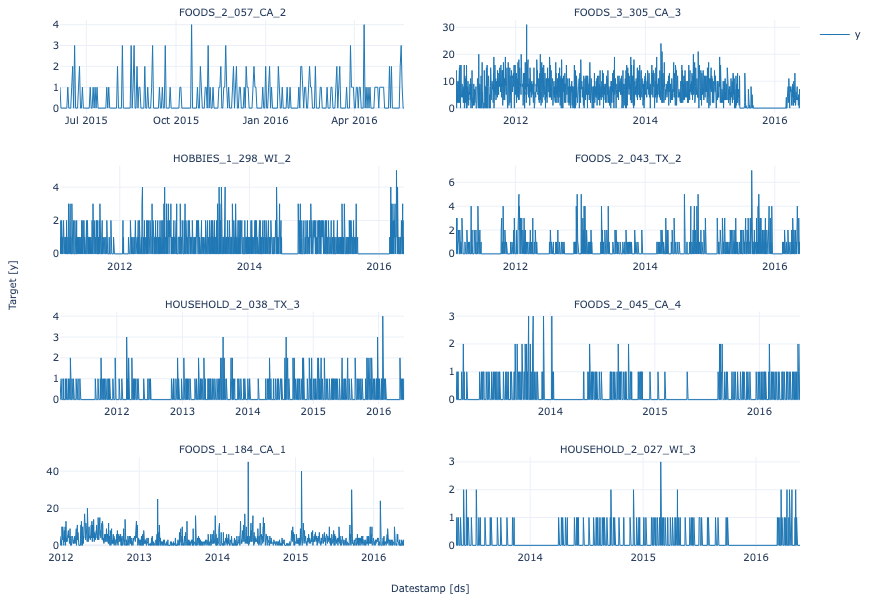

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(Y_df)

From the exploration, we can conclude that a key feature of this dataset is that many of the items have no sales on numerous days, a common characteristic of such data when observed at a low level of granularity. In order to build forecasts at the store-item, we will need to employ techniques specifically designed to deal with intermittent (sporadic) values.


### 2. Train multiple models with StatsForecast

We fit the model by instantiating a new `StatsForecast` object with the following parameters:

* `models`: a list of models. Select the models you want from [models](../models.ipynb) and import them. For this example, we will use `AutoETS` and `DynamicOptimizedTheta`. We set `seson_length` to 7 because we expect seasonal effects every week. (See: [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/))

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs`: n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model`: a model to be used if a model fails. 

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

:::{.callout-note}
StatsForecast achieves its blazing speed using JIT compiling through Numba. The first time you call the statsforecast class, the fit method should take around 5 seconds. The second time -once Numba compiled your settings- it should take less than 0.2s. 
:::

* ETS: Exponential Smoothing model. Automatically selects the best ETS (Error, Trend, Seasonality) model using an information criterion. Ref: `ETS`

* Holt Winters: Also known as triple exponential smoothing, Holt-Winters’ method is an extension of exponential smoothing for series that contain both trend and seasonality. Ref: `HoltWinters`

* Croston: A method to forecast time series that exhibit intermittent demand. Ref: `CrostonClassic`

* Adida: Aggregate-Dissagregate Intermittent Demand Approach: Uses temporal aggregation to reduce the number of zero observations. Ref: `ADIDA`

* IMAPA: Intermittent Multiple Aggregation Prediction Algorithm: Similar to ADIDA, but instead of using a single aggregation level, it considers multiple in order to capture different dynamics of the data. Ref: `IMAPA`


* SeasonalNaive: Memory Efficient Seasonal Naive predictions. Ref: `SeasonalNaive`

* Historic Average: Also known as mean. Ref: `HistoricAverage`



In [ ]:
from statsforecast.models import (
    AutoETS,
    SeasonalNaive,
    DynamicOptimizedTheta
)

# Create list of models
models = [
    AutoETS(season_length=7),
    DynamicOptimizedTheta(season_length=7),
    SeasonalNaive(season_length=7)
]

# Instantiate StatsForecast class
sf = StatsForecast( 
    models=models,
    freq='D', 
    n_jobs=-1,
    fallback_model=SeasonalNaive(season_length=7)
)


The `forecast` method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h` (int): represents the forecast h steps into the future. In this case, 12 months ahead. 

* `level` (list of floats): this optional parameter is used for probabilistic forecasting. Set the `level` (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times. 

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

:::{.callout-note}
The `forecast` is inteded to be compatible with distributed clusters, so it does not store any model parameters. If you want to store parameter for everymodel you can use the `fit` and `predict` methods. However, those methods are not defined for distrubed engines like Spark, Ray or Dask.
:::

In [ ]:
from time import time

In [ ]:
init = time()
forecasts_df = sf.forecast(df=Y_df, h=28)
end = time()
print(f'Statsforecast time {(end - init) / 60}')

Statsforecast time 14.654126946131388


Plot the results of 8 random series using the `StatsForecast.plot` method. 

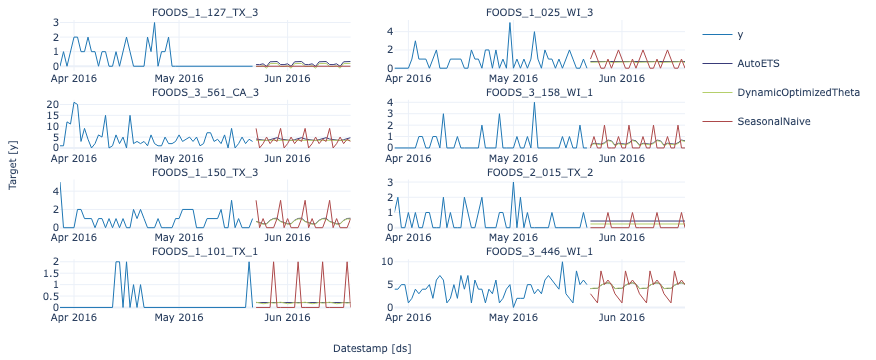

In [ ]:
sf.plot(Y_df, forecasts_df, max_insample_length=28 * 2)

The `StatsForecast.plot` allows for further customiation. For example, plot the results of the ETS model and the Mean for the last year for two Specifics Products in two stores.

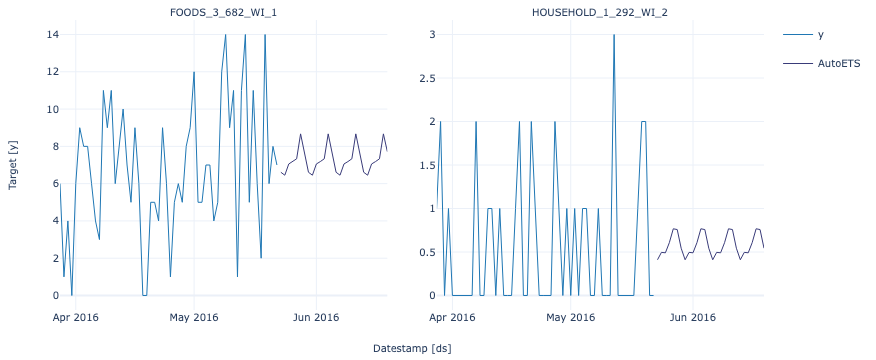

In [ ]:
sf.plot(Y_df, forecasts_df, 
        models=["AutoETS"], 
        unique_ids=["FOODS_3_682_WI_1", "HOUSEHOLD_1_292_WI_2"], 
        max_insample_length=28 * 2)

In [ ]:
forecasts_df['ThETS'] = forecasts_df[['DynamicOptimizedTheta', 'AutoETS']].clip(0).median(axis=1, numeric_only=True)

In the next notebook, we will evaluate the performance of the models.

In [ ]:
forecasts_df.to_parquet('s3://m5-benchmarks/forecasts/statsforecast-m5.parquet')

## M4 Dataset

### 1. Read the data.

In [ ]:
Y_df = pd.read_parquet('s3://m4-benchmarks/data/train/target.parquet') 

Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'target_value': 'y'
})


In [ ]:
Y_df.head()

,unique_id,ds,y
0,D1,2019-03-18,1017.1
1,D1,2019-03-19,1019.3
2,D1,2019-03-20,1017.0
3,D1,2019-03-21,1019.2
4,D1,2019-03-22,1018.7


#### 1.1 Explore Data

In [ ]:
len(Y_df['unique_id'].unique())

4227

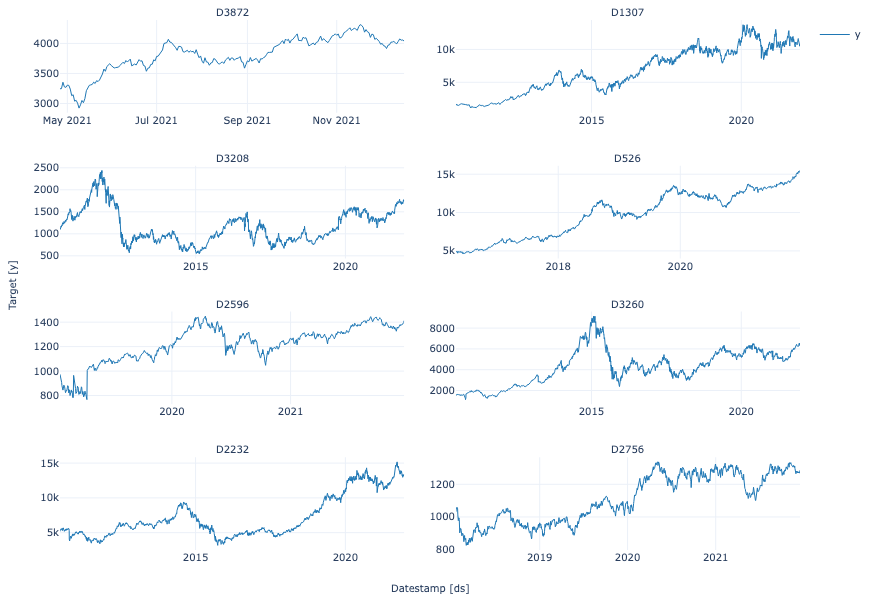

In [ ]:
StatsForecast.plot(Y_df)

### 2. Train multiple models with StatsForecast

In [ ]:
init = time()
forecasts_df = sf.forecast(df=Y_df, h=14)
end = time()
print(f'Statsforecast time {(end - init) / 60}')

Statsforecast time 11.896545020739238


Plot the results of 8 random series using the `StatsForecast.plot` method. 

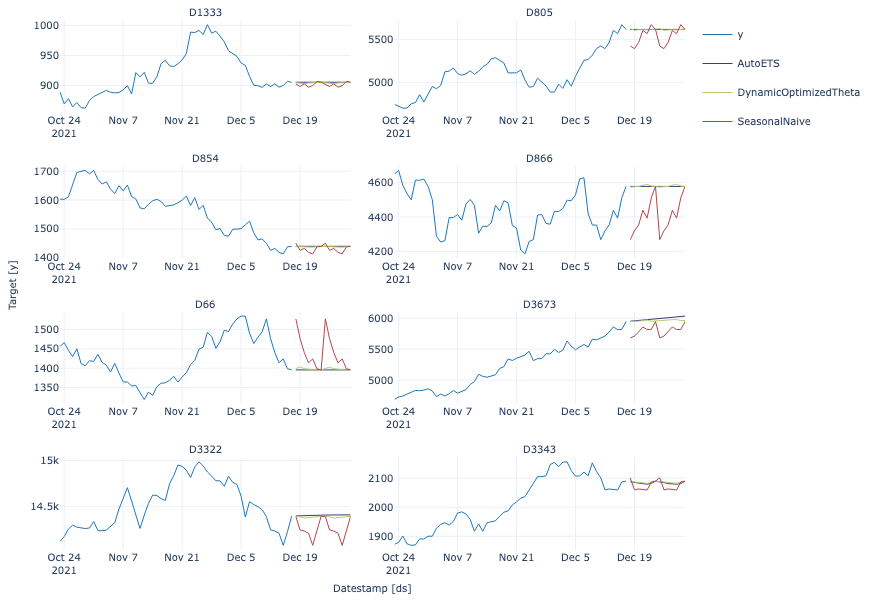

In [ ]:
sf.plot(Y_df, forecasts_df, max_insample_length=28 * 2)

The `StatsForecast.plot` allows for further customiation. For example, plot the results of the ETS model and the Mean for the last year for two Specifics Products in two stores.

In [ ]:
forecasts_df['ThETS'] = forecasts_df[['DynamicOptimizedTheta', 'AutoETS']].clip(0).median(axis=1, numeric_only=True)

In the next notebook, we will evaluate the performance of the models.

In [ ]:
forecasts_df.to_parquet('s3://m4-benchmarks/forecasts/statsforecast-m4-daily.parquet')